# Preprocessing

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch

In [4]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json


ModuleNotFoundError: No module named 'vfm'

In [ ]:
connection = Connection()
# Get client
client = connection.get_client()

In [ ]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [ ]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [ ]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 86
W15 Record count after preprocessing: 86
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproc

755

In [ ]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [ ]:
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=515, Validation=84, Test=156


In [ ]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [ ]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)

[WARN] Initial physics fit failed for well W06: name 'least_squares' is not defined
[WARN] Initial physics fit failed for well W08: name 'least_squares' is not defined
[WARN] Initial physics fit failed for well W10: name 'least_squares' is not defined
[WARN] Initial physics fit failed for well W11: name 'least_squares' is not defined
[WARN] Initial physics fit failed for well W15: name 'least_squares' is not defined
[WARN] Initial physics fit failed for well W18: name 'least_squares' is not defined
[WARN] Initial physics fit failed for well W19: name 'least_squares' is not defined
[WARN] Geometry-aware fit failed for well W06, falling back: name 'least_squares' is not defined


NameError: name 'least_squares' is not defined

In [ ]:
physics_scores = model.score_physics(df_train)
physics_scores

{'W06': {'qo': {'r2': 0.6980821951703269,
   'mae': 15.365088102076795,
   'rmse': 20.080963435119077,
   'mape (%)': 18.890040335047207,
   'mpe (%)': 9.787863635837688},
  'qw': {'r2': 0.05678150278958194,
   'mae': 1.0259669476967892,
   'rmse': 1.2151358643540482,
   'mape (%)': 14072.86095984542,
   'mpe (%)': 14036.561711848113},
  'qg': {'r2': 0.6631822874157105,
   'mae': 2206.545675914606,
   'rmse': 2845.9676246467166,
   'mape (%)': 445.5850031683301,
   'mpe (%)': 422.03202494987966},
  'wgr': {'r2': -0.6707724464461362,
   'mae': 7.76744734173656e-05,
   'rmse': 0.00010354304161946666,
   'mape (%)': 583.9396732972966,
   'mpe (%)': 551.2156559780399},
  'gor': {'r2': -3.8689429667273716,
   'mae': 18.986659546809342,
   'rmse': 31.124726929579595,
   'mape (%)': 336.7817827756594,
   'mpe (%)': 309.7221794558879}},
 'W08': {'qo': {'r2': -1.199987510802171,
   'mae': 14.661023938554674,
   'rmse': 17.647133200219454,
   'mape (%)': 59.99003319546239,
   'mpe (%)': -32.5114

In [ ]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.8577275607654484,
   'mae': 10.85515814380501,
   'rmse': 13.307415146275844,
   'mape (%)': 9.221150379667442,
   'mpe (%)': -1.3224785827243433},
  'qw': {'r2': -0.8274126476193144,
   'mae': 1.2506056617761354,
   'rmse': 1.8585644511268058,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.9379445082119626,
   'mae': 982.7114837546569,
   'rmse': 1320.5656155396723,
   'mape (%)': 598.5356918802314,
   'mpe (%)': 593.2303880071189},
  'wgr': {'r2': -1.2619773699221946,
   'mae': 0.00011610091936055756,
   'rmse': 0.00015543685592702309,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': 0.8648291385354913,
   'mae': 9.148199444248036,
   'rmse': 11.040114318713163,
   'mape (%)': 485.49297537493584,
   'mpe (%)': 483.06771600278955}},
 'W08': {'qo': {'r2': 0.46377902037966545,
   'mae': 8.298644379108788,
   'rmse': 10.898573845889024,
   'mape (%)': 44.380986278808535,
   'mpe (%)': 17.345051464974432},
  'qw': {'r2': 0.243096561737897

In [ ]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9639026791716808,
   'mae': 5.032858277518319,
   'rmse': 6.703024419906371,
   'mape (%)': 4.187171708069496,
   'mpe (%)': 3.6222214152396184},
  'qw': {'r2': -0.2919605629745643,
   'mae': 1.0752622094035544,
   'rmse': 1.5627299712141318,
   'mape (%)': 1424.1743525138752,
   'mpe (%)': 1260.5711863244217},
  'qg': {'r2': 0.8414099923006251,
   'mae': 1374.6966838960489,
   'rmse': 2111.0950347399394,
   'mape (%)': 2869.7762805396274,
   'mpe (%)': 2869.7762805396274},
  'wgr': {'r2': -0.32598346215028906,
   'mae': 9.518119558078624e-05,
   'rmse': 0.00011900875968470595,
   'mape (%)': 133.6281259481659,
   'mpe (%)': -34.84233022255234},
  'gor': {'r2': -0.444671754214754,
   'mae': 12.983877014947351,
   'rmse': 36.092471357349666,
   'mape (%)': 2969.5912011366327,
   'mpe (%)': 2968.377891601419}},
 'W08': {'qo': {'r2': 0.34548844306393744,
   'mae': 7.330761363505093,
   'rmse': 12.040830146076269,
   'mape (%)': 44.71293327842877,
   'mpe (%)': 27.0

In [ ]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

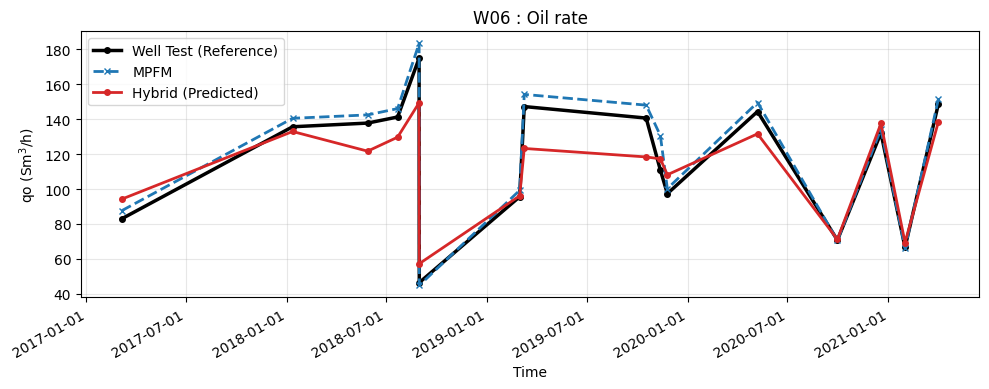

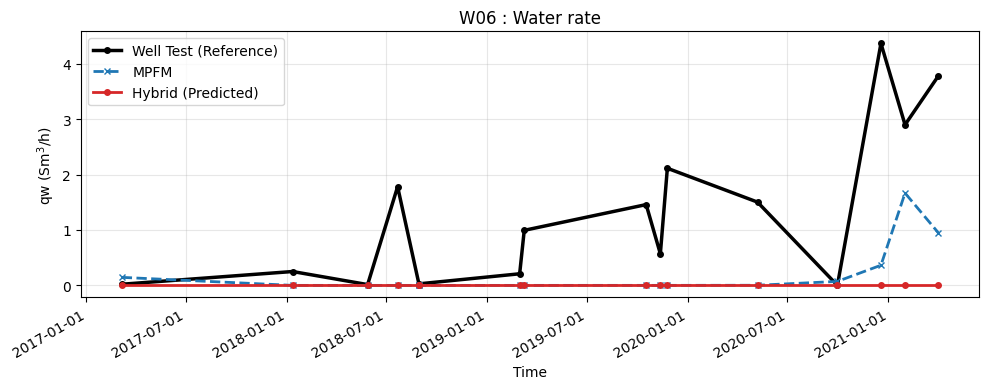

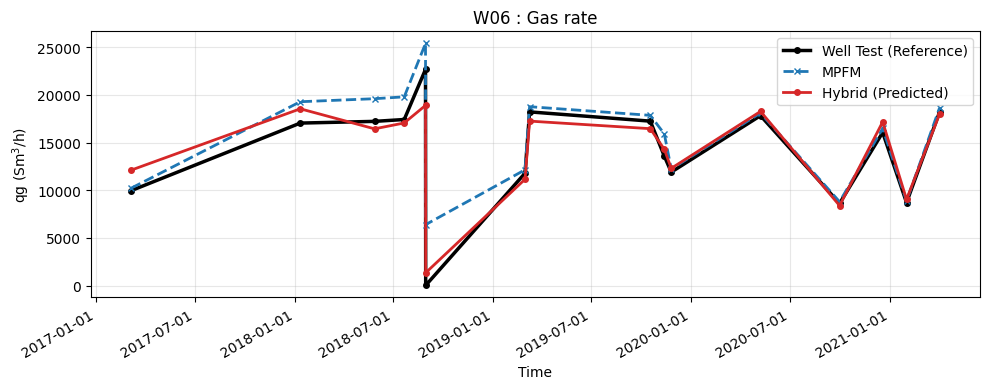

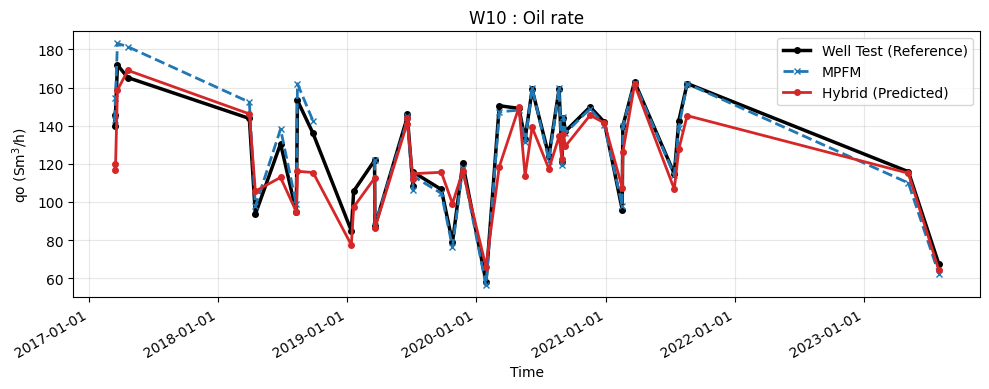

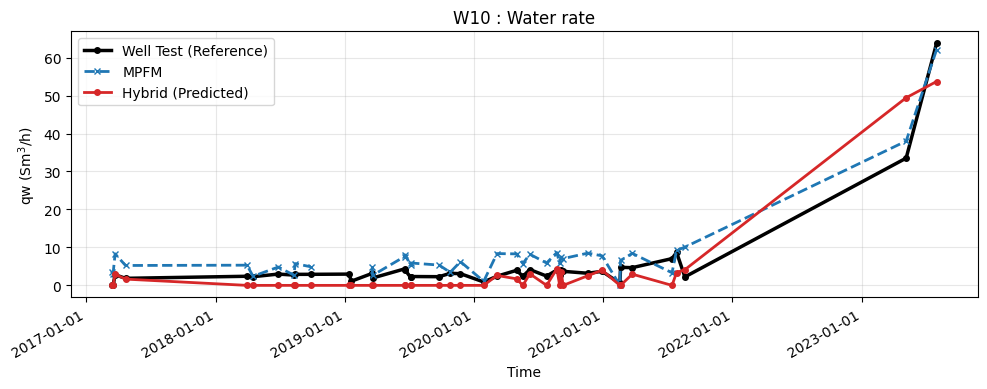

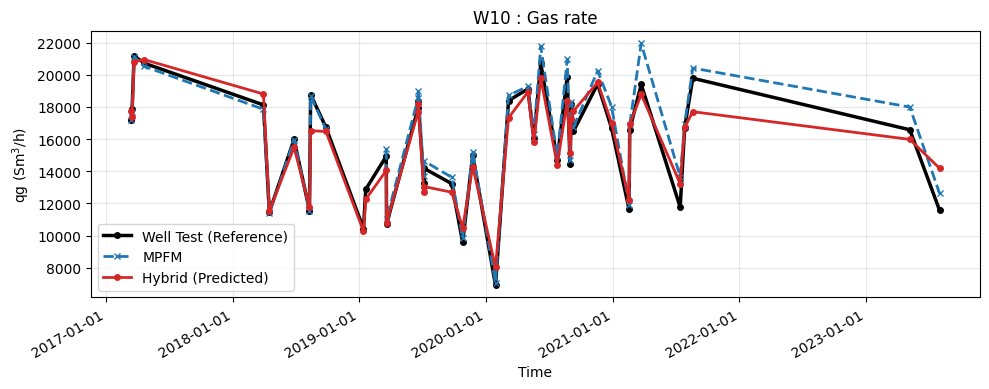

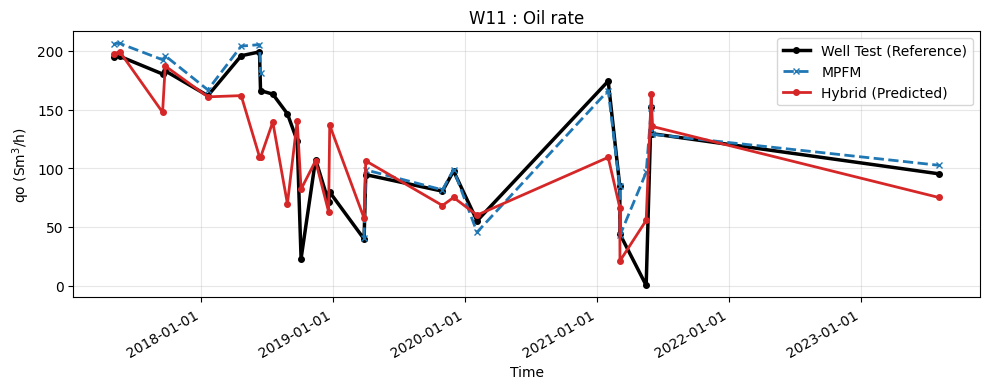

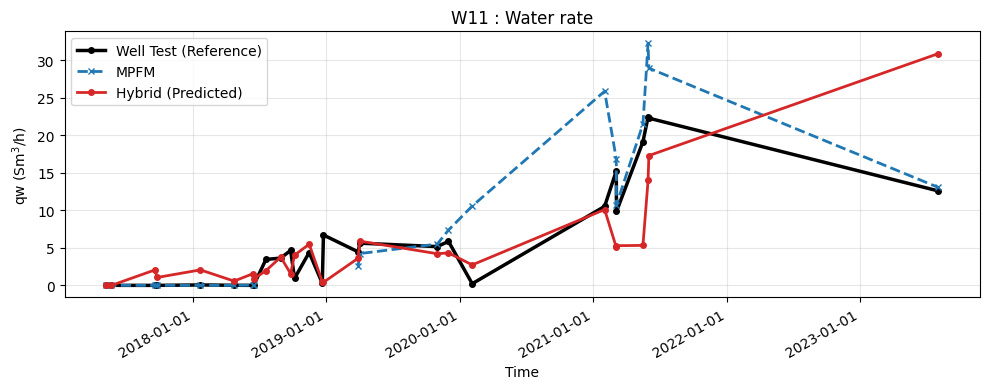

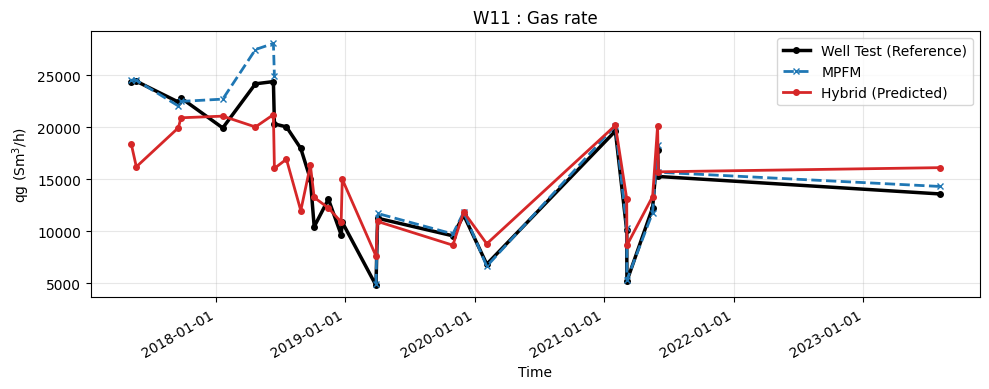

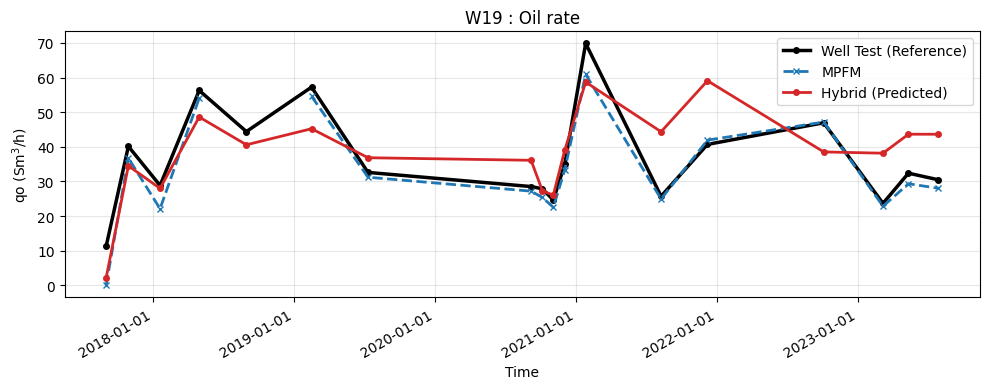

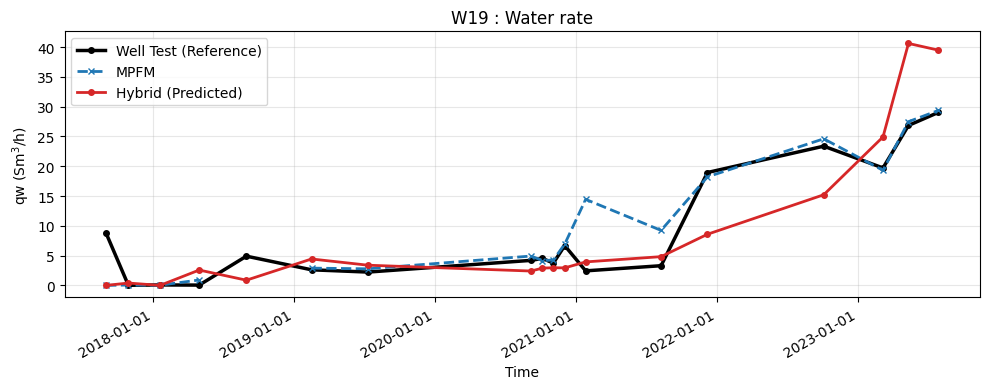

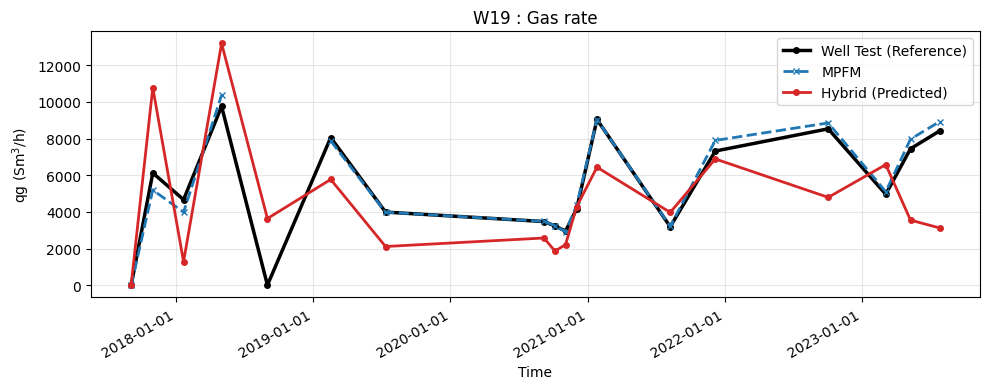

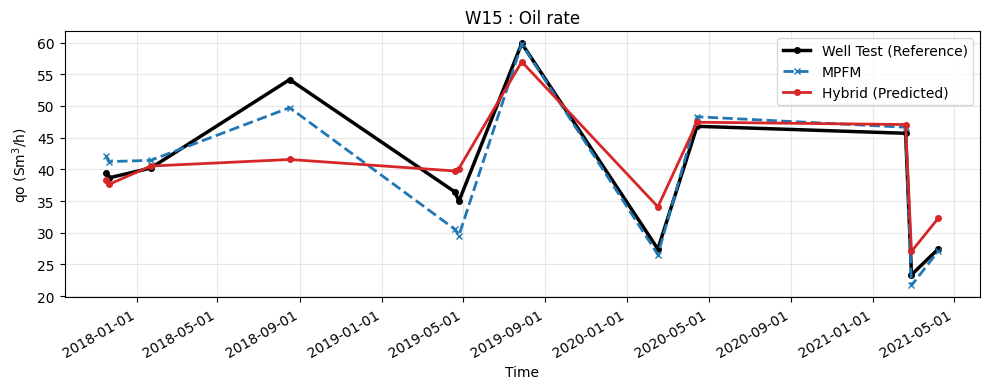

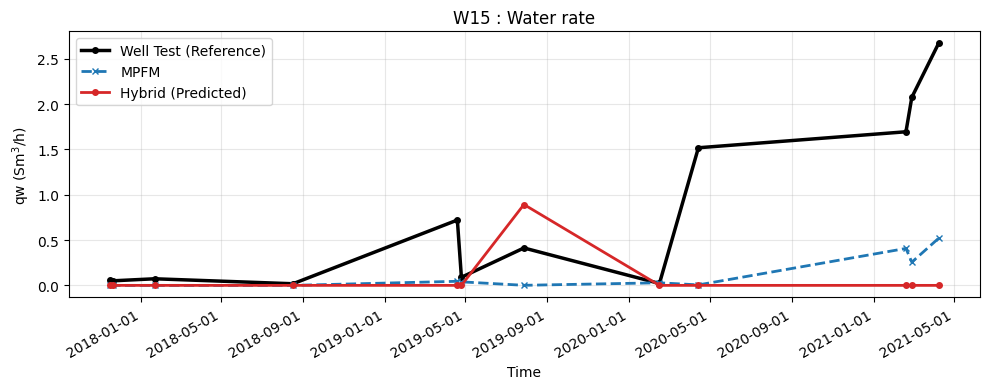

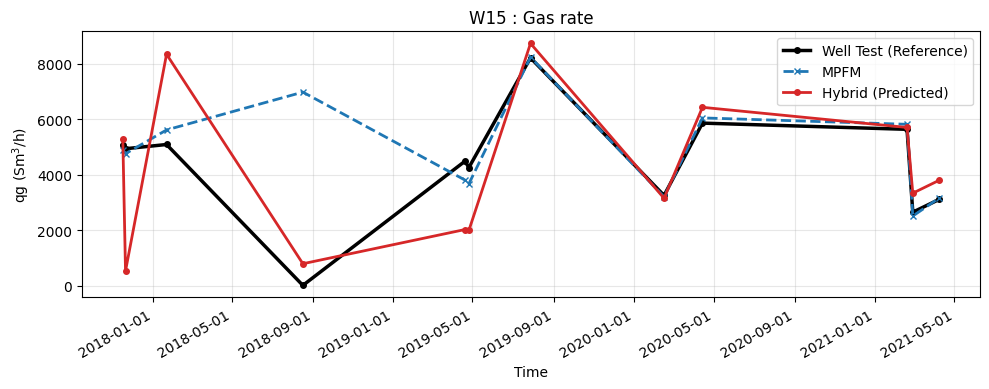

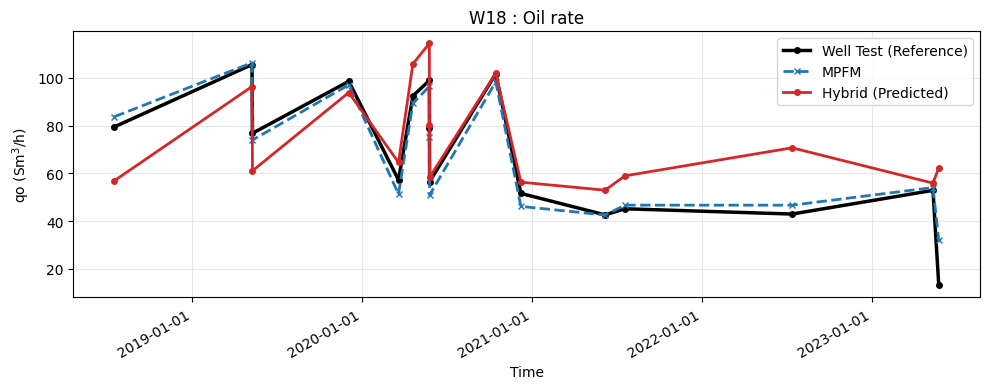

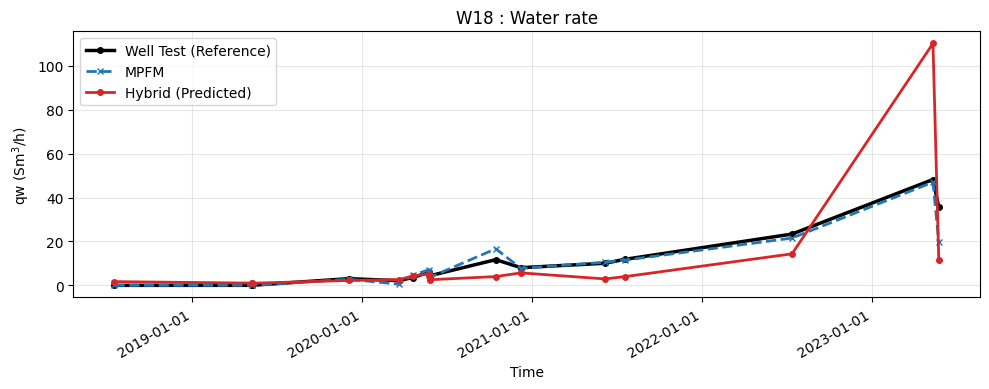

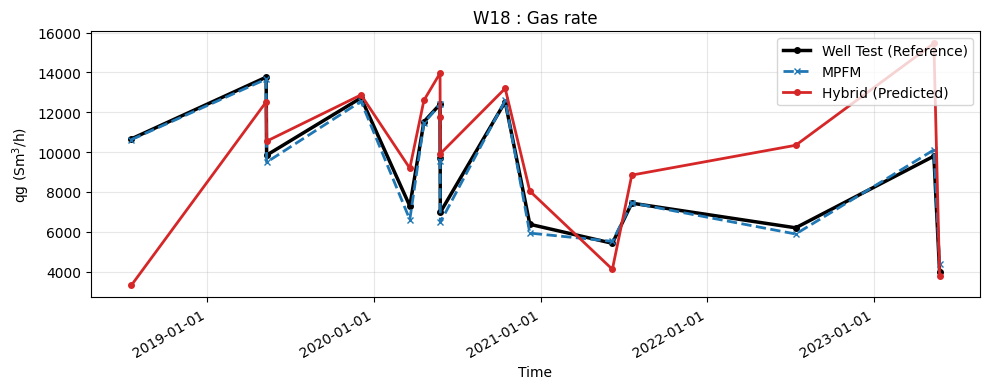

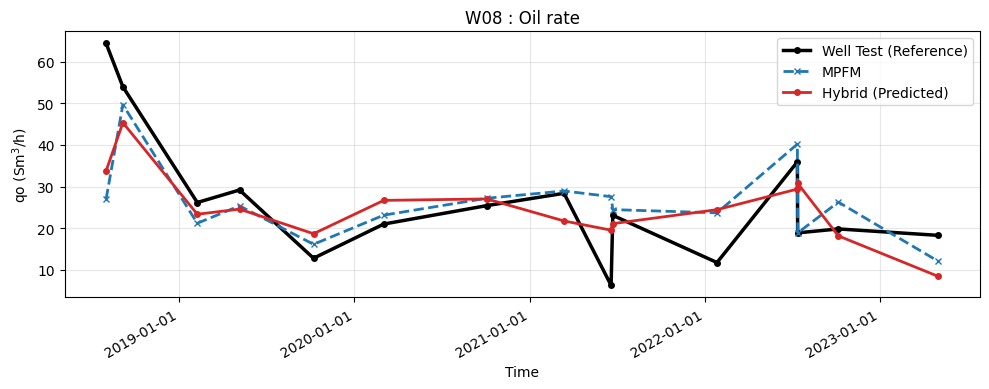

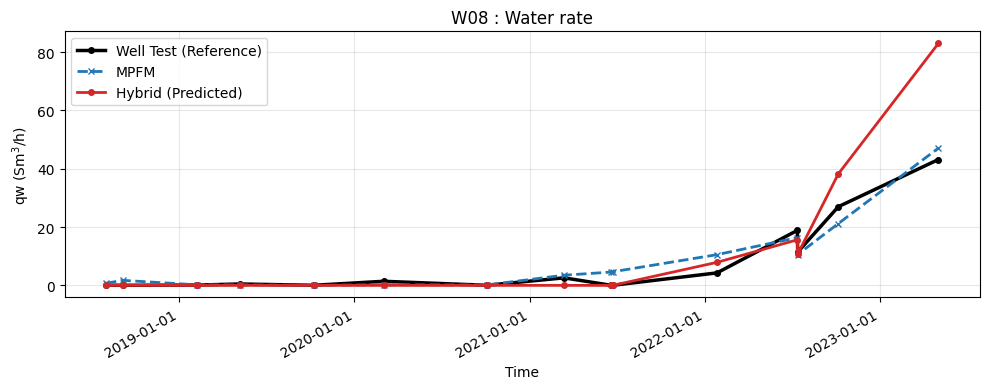

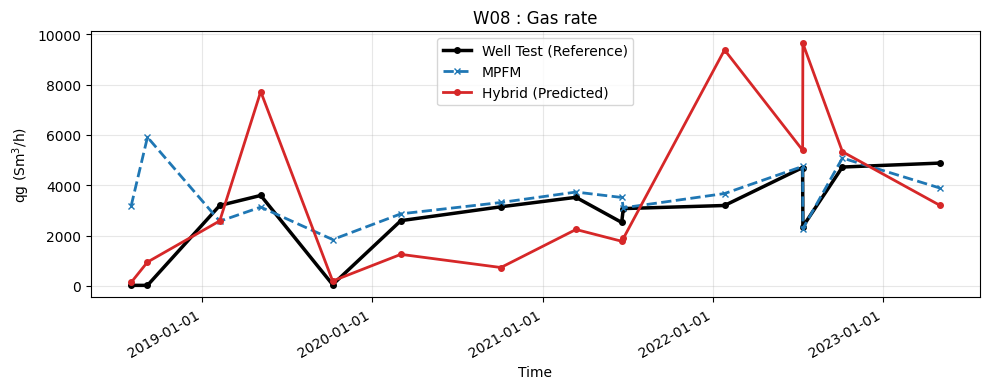

In [ ]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [ ]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=426, Val=108, Calibration=30, Test=191


In [ ]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.8159


In [ ]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

NameError: name 'PhysicsModel' is not defined

In [ ]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.5291197266761081,
   'mae': 16.435619203301357,
   'rmse': 21.906883023825635,
   'mape (%)': 16.59696154573153,
   'mpe (%)': 3.362836685994782},
  'qw': {'r2': 0.29769301289511874,
   'mae': 4.297116916571757,
   'rmse': 8.2389435639281,
   'mape (%)': 348408.0810340519,
   'mpe (%)': 348321.78600648895},
  'qg': {'r2': 0.5089710616202627,
   'mae': 2104.8714342835533,
   'rmse': 2737.1713466363894,
   'mape (%)': 15.137093786225716,
   'mpe (%)': -7.008994394349228},
  'wgr': {'r2': 0.3157833469305258,
   'mae': 0.0003470140901070607,
   'rmse': 0.0007168995178313606,
   'mape (%)': 176.33105604124165,
   'mpe (%)': 87.42930436520086},
  'gor': {'r2': -6.660011960977828,
   'mae': 15.604694341752626,
   'rmse': 26.92077281621244,
   'mape (%)': 12.362769785765718,
   'mpe (%)': -6.162054752856555}}}

In [ ]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.5803985305517974,
   'mae': 16.769599941234468,
   'rmse': 20.679681280793424,
   'mape (%)': 15.317586905769842,
   'mpe (%)': -4.8284323529758755},
  'qw': {'r2': 0.12382421570985791,
   'mae': 4.17915346788768,
   'rmse': 9.202454025061083,
   'mape (%)': 114716.28533214859,
   'mpe (%)': 114587.14846046238},
  'qg': {'r2': -0.5652901540021011,
   'mae': 4020.9374555098166,
   'rmse': 4887.039710117928,
   'mape (%)': 32.80327052379914,
   'mpe (%)': -26.98876773208282},
  'wgr': {'r2': -0.21787671947125165,
   'mae': 0.00036577238872774834,
   'rmse': 0.0009564518962854706,
   'mape (%)': 111.16685209668526,
   'mpe (%)': -20.77471601415069},
  'gor': {'r2': -29.127346189796036,
   'mae': 43.676051694447445,
   'rmse': 53.38917846319493,
   'mape (%)': 34.85752052337314,
   'mpe (%)': -21.572367881621258}}}

In [ ]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9696780204258658,
   'mae': 3.7605142433093786,
   'rmse': 5.591866145430611,
   'mape (%)': 3.050488696205528,
   'mpe (%)': 0.7898581253981392},
  'qw': {'r2': 0.9063960016765633,
   'mae': 2.5835447431858687,
   'rmse': 3.0281743507708963,
   'mape (%)': 564847.8055638927,
   'mpe (%)': 564837.2105399013},
  'qg': {'r2': 0.9702635694819423,
   'mae': 429.2541790219124,
   'rmse': 677.3433706951082,
   'mape (%)': 2.860984240514515,
   'mpe (%)': 2.030025466043167},
  'wgr': {'r2': 0.9400305814036114,
   'mae': 0.00017121588459590657,
   'rmse': 0.00021378835341335402,
   'mape (%)': 151.00981045261832,
   'mpe (%)': 138.93039187439774},
  'gor': {'r2': 0.18630922137197936,
   'mae': 6.645454528171876,
   'rmse': 8.837807928050456,
   'mape (%)': 5.212374533098269,
   'mpe (%)': 1.444301189361481}}}

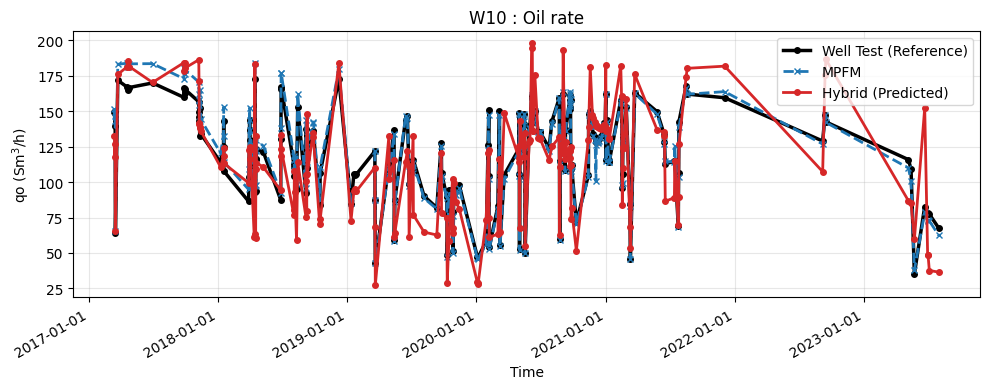

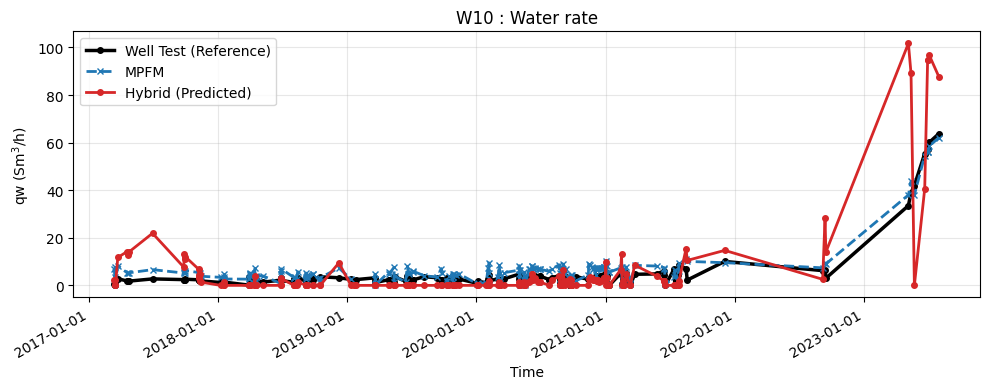

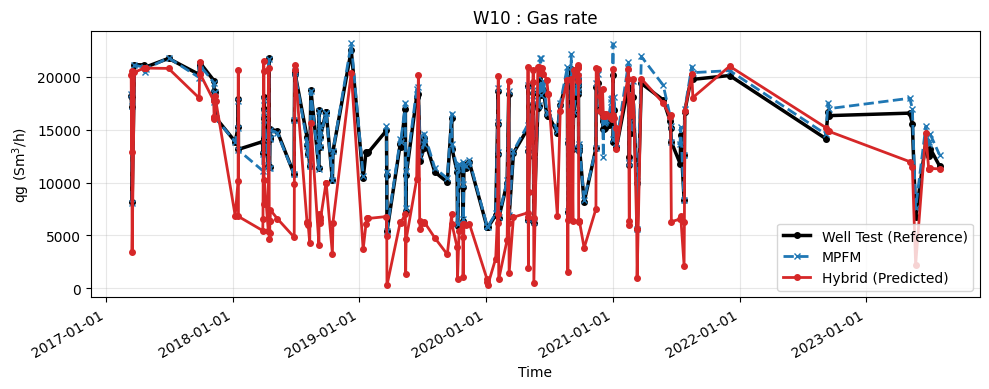

In [ ]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [ ]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [ ]:
# df_resampled.index

In [ ]:
# df_resampled.columns

In [ ]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [ ]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [ ]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [ ]:
# summarize_null(df_generated)